# INTRODUCTION

For this project, we are exploring what the best neighborhood in Pittsburgh is based on our metric of livaility. We decided that the best way to figure out what the best neighborhood in Pittsburgh is would be to measure how livable the neighborhoods are for families based on different factors such as safety, walkability, schools and affordability that a family would consider when finding a place to live. 

# THE METRIC

Our metric of liveabilty is based on general factors a family would consider when trying to find a neighborhood to live in. The factors/submetrics are safety, walkability, schools and affordability. We figured that a neighborhood that ranks high in the data for all of these factors would be the best neighborhood. 
We are using homeownership data, number of public schools and enrollment data as well as crime stats and walk score data. 

In [10]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Load census CSVS
neighborhoods = pd.read_csv("https://data.wprdc.org/dataset/95af9f2c-61c8-446b-ae72-852e195684f3/resource/6b09ea3e-7d34-4665-ad0b-798a0efadc29/download/index_pittsburghneighborhoods_blocks_2020.csv")
housing = pd.read_csv("https://data.wprdc.org/dataset/63d09e2c-931c-4c66-86e0-844b84d2a8ad/resource/85ec763a-457e-4025-8263-112baeba0fdb/download/housingrentown.csv")
neighborhood_enrollment = pd.read_csv("https://data.wprdc.org/dataset/27b6eef7-8825-4cc4-8b48-52c17ac80d37/resource/7b0660d1-c812-496d-ab0a-8560902e9e70/download/neighborhood_school_enrollment.csv")
walkability = pd.read_csv("https://data.wprdc.org/dataset/853a077d-0a31-4292-8a1d-5d60b530169b/resource/ab8db07e-09ef-45c4-bad2-f7d32bfc5f26/download/sidewalkstreetratiotract.csv")
groceries = pd.read_csv("https://data.wprdc.org/dataset/690409e3-27e2-47a1-beed-fd600097f951/resource/626357fa-c95d-465f-9a02-3121655b2b78/download/data-conveniencesupermarkets.csv")
#zips = pd.read_csv("https://data.wprdc.org/datastore/dump/0c781f02-2bb9-4d0c-9c45-879bde957f34")

# group by tract and neighborhood
grouped = neighborhoods.groupby(['TRACT'])['Neighborhood'].apply(lambda x: ', '.join(x)).reset_index()
neighborhoods = grouped.rename(columns={'TRACT': 'Census Tract'})

In terms of selecting the best neighborhood for livability for a family of four, homeownership is a very important role. High homeownership in an area tends to mean that a neighborhood is affordable enough for people to buy homes instead of rent them. It can also mean the schooling in an area is better. 

# WALKABILITY

In terms of selecting the best neighborhood for livability for a family of four, walkability is a very important role. Walkability has become an indicator of urban livability and quality of life.

In [11]:
walkability = walkability.rename(columns={'Tract': 'Census Tract'})
walkability['Census Tract'] = walkability['Census Tract'].astype(str).apply(lambda x: x[6:])
walkability['Census Tract'] = walkability['Census Tract'].astype(str).apply(lambda x: x[:-4])

In [12]:
merged = pd.merge(neighborhoods, walkability[['Census Tract', 'Ratio']], on='Census Tract', how='inner')
merged['Neighborhood'] = merged['Neighborhood'].str.split(',').str[0]

merged = merged[pd.to_numeric(merged['Ratio'], errors='coerce').notnull()]
merged['Ratio'] = merged['Ratio'].astype(float)
merged = merged.sort_values(by=['Ratio'], ascending=[False]).head(10)

# graph
plt.bar(merged['Neighborhood'][:10], merged['Ratio'][:10])
plt.xticks(rotation=90)
plt.xlabel('Neighborhoods')
plt.ylabel('Ratio')
plt.title('Pittsburgh Neighborhoods With Highest Walkability')
plt.show()

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [ ]:
# GROCERIES AND FOOD

In [ ]:
In terms of selecting the best neighborhood for livability for a family of four, food plays a huge role

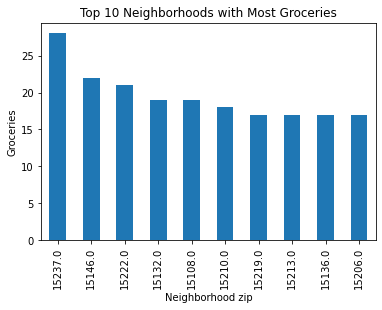

In [7]:
# group by neighborhood and sum up enrolled students per neighborhood
df = groceries['Zip'].value_counts().sort_values(ascending=True)
# sort by most in decending 
df = df.sort_values(ascending=[False]).head(10)

# McKnight, 
df.plot(kind='bar', title='Top 10 Neighborhoods with Most Groceries', xlabel='Neighborhood zip', ylabel='Groceries')
plt.show()

# Conclusion

Ohenmaa - Squirrel Hill is my favorite neighborhood just because it is pretty. I assumed that the data would fall in its favor just based off of how high praised it is but honestly was not expecting it to appear in all 3 graphs the way it did. I guess it really is the best. 